In [ ]:
%load_ext rpy2.ipython

v = 2

In [1]:
%%R -i v
print(v)

UsageError: Cell magic `%%R` not found.


#### 17.05 - Reproduce Oliver 

In the paper from Oliver, they wanted to represent a worldwide trend of the association between coral cover and heat by using Linear Mixed Models (LMM) where they added **random factors//additional variables** where each observation comes from.

This enables the model to first check for baseline difference between regions and tries to explain the differences with respect to temperature ect....
- The ocean region
- The study areas
- Survey sites located up to 100 km of distance from each other (corresponds to average value of the mean Euclidian distances measured between survey sites) // ours will be smaller here 
- Survey sites located up to 7 km (minimal Euclidian distances between survey sites)

Instead of having 4 random factors we will have 3 because all our variables are located within the same Oceanic region 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

import pyproj as proj
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import data_processing_helper as dp
import practical_functions as pf

import warnings
warnings.filterwarnings("ignore")


####
# For categorical encoding
from sklearn.preprocessing import OrdinalEncoder
# Compute the distances between all surveys 
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import ward, fcluster

In [ ]:
df = pd.read_csv("../Data/df_all_17_05.csv")
dp.geo_loads(df)
df = pf.make_geo_frame(df)

In [6]:
df = df

### Define the three random factors which will be used in the generalized linear mixture model
- Study areas (4 levels)
- Survey sites located up to average distance
- Survey sites located up to min 

In [7]:
ord_enc = OrdinalEncoder()
df["country_code"] = ord_enc.fit_transform(df[["country"]])

#AUS - 0
# IDN - 1
# SLB - 2
# TLS - 3

In [8]:
# Study areas
df.drop(columns = "country", inplace = True)

In [9]:
## Only keep different places else the distances between those will be very small // Different transectID

In [10]:
df_diff_surveys = df.drop_duplicates(subset='transectid', keep='first')

In [11]:
def project(df):
    crs_wgs = proj.Proj(init='epsg:4326') 
    crs_bng = proj.Proj(init='epsg:3112') # use a locally appropriate projected CRS

    # then cast your geographic coordinate pair to the projected system
    x, y = proj.transform(crs_wgs, crs_bng, df["lon"][:].to_list(), df["lat"][:].to_list())    
    XY = [list(a) for a in zip(x,y)]
    y_ = pdist(XY)
    return y_
y_ = project(df_diff_surveys)
Z = ward(y_)

(array([8005., 1499., 3993., 2930., 2672., 4396., 1978., 3675.,  362.,
         380.]),
 array([2.25116180e+01, 5.53660703e+05, 1.10729890e+06, 1.66093709e+06,
        2.21457528e+06, 2.76821347e+06, 3.32185166e+06, 3.87548985e+06,
        4.42912805e+06, 4.98276624e+06, 5.53640443e+06]),
 <BarContainer object of 10 artists>)

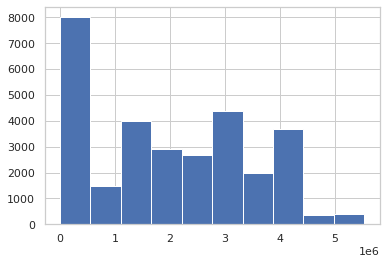

In [12]:
plt.hist(y_)

In [13]:
peak_1_hist = 0.55*1e6

I first computed the average distance between survey locations of every study area, resulting in twelve regional averages (one for Australia, one for Solomon, one for Indonesia, etc.). The local threshold is the minimum of these regional averages, the regional threshold is the average of these regional averages.

In [14]:
def avg_dist(dist):
    return dist.mean()    

In [15]:
#AUS - 0
# IDN - 1
# SLB - 2
# TLS - 3
df_AUS = df_diff_surveys[df_diff_surveys["country_code"] == 0]
df_IDN = df_diff_surveys[df_diff_surveys["country_code"] == 1]
df_SLB = df_diff_surveys[df_diff_surveys["country_code"] == 2]
df_TLS = df_diff_surveys[df_diff_surveys["country_code"] == 3]

In [16]:
y_AUS = project(df_AUS)
Z_AUS = ward(y_AUS)
y_IDN = project(df_IDN)
Z_IDN = ward(y_IDN)
y_SLB = project(df_SLB)
Z_SLB = ward(y_SLB)
y_TLS = project(df_TLS)
Z_TLS = ward(y_TLS)

dist = [avg_dist(y_AUS),avg_dist(y_IDN),avg_dist(y_SLB),avg_dist(y_TLS)]
local_ = min(dist)
regional_ = np.mean(dist)


#### All together
Several problems:
- Not enough precision seems to be causing the distance between two surveys from different points to be closer together than surveys taken at the same transectID 

In [17]:
import pyproj as proj
crs_wgs = proj.Proj(init='epsg:4326') 
crs_bng = proj.Proj(init='epsg:3112') # use a locally appropriate projected CRS

# then cast your geographic coordinate pair to the projected system
x, y = proj.transform(crs_wgs, crs_bng, df["lon"][:].to_list(), df["lat"][:].to_list())    
XY_all = [list(a) for a in zip(x,y)]
y_all = pdist(XY_all)
Z_all = ward(y_all)

In [18]:
local_clusters = fcluster(Z_all, local_, criterion='distance')
regional_clusters = fcluster(Z_all, regional_, criterion='distance')
peak1_clusters = fcluster(Z_all, peak_1_hist, criterion='distance')

In [19]:
df["local_clusters"]= local_clusters
df["regional_clusters"]= regional_clusters
df["peak1_clusters"] = peak1_clusters

In [20]:
df.drop(columns = ["geometry", "lat", "lon"], inplace = True)
df["cst"] = 1

## If the distances would be right, this would result to a similar dataframe to that of Oliver 
Now it's time to build the GLMM's with the response variable being hard coral cover, where you can use beta regression method to model their response

the five explanatory variables are the DHW averages

For univariate GLMM:
- Association between hard coral cover and DHW_1avg_year, DHW10 years and DHW 20 years
--> Goal: evaluate how local patterns of coral cover can be explained by recent and past heat stress


Fpr bi-variate GLMM's
- Not there yet


# Using R in Python

In [21]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

# import R's "base" package
base = importr('base')
# import R's "utils" package
utils = importr('utils')
from rpy2.robjects.vectors import StrVector

In [22]:
import rpy2
from rpy2.robjects.packages import importr
utils = importr("utils")
d = {'print.me': 'print_dot_me', 'print_me': 'print_uscore_me'}
try:
    visreg = importr('visreg', robject_translations = d, lib_loc = "/usr/local/lib/R/site-library")
    glmmTMB = importr('glmmTMB', robject_translations = d, lib_loc = "/usr/local/lib/R/site-library")
except:
    try:
        visreg = importr('visreg', robject_translations = d, lib_loc = "/usr/lib/R/site-library")
        glmmTMB = importr('glmmTMB', robject_translations = d, lib_loc = "/usr/lib/R/site-library")
    except:
        visreg = importr('visreg', robject_translations = d, lib_loc = "/home/lavinia/R/x86_64-pc-linux-gnu-library/3.6")
        glmmTMB = importr('glmmTMB', robject_translations = d, lib_loc = "/home/lavinia/R/x86_64-pc-linux-gnu-library/3.6")


In [23]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
with localconverter(ro.default_converter + pandas2ri.converter):
    
    df_r = ro.conversion.py2rpy(df)
        

In [24]:

# write pandas dataframe to an .RData file
def save_rdata_file(df, filename):
    r_data = df
    robjects.r.assign("all_data_19", r_data)
    robjects.r("save(all_data_19, file='{}')".format(filename))
save_rdata_file(df_r, "all_data_19.rda")

#ro.r.glmmTMB("cc ~ datasets)",data=v)
#Oliver

ro.r('''
                    library(glmmTMB)
                    library(visreg)
                    load('data.rda', verbose = TRUE)
                    MOD1 = glmmTMB(cc ~ 1 +  (1 | datasets/studyarea/spaclL/spacl),data=data,family=beta_family())
                    summary(MOD1)
                    visreg(MOD1, scale = 'response', partial=T)
            
            ''')

Loading objects:
  all_data_19
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/regional_clusters/local_clusters)
Data: all_data_19

     AIC      BIC   logLik deviance df.resid 
 -1018.4   -998.2    514.2  -1028.4      411 

Random effects:

Conditional model:
 Groups                                          Name        Variance 
 local_clusters:(regional_clusters:country_code) (Intercept) 4.959e-02
 regional_clusters:country_code                  (Intercept) 1.572e-01
 country_code                                    (Intercept) 2.955e-09
 Std.Dev. 
 2.227e-01
 3.965e-01
 5.436e-05
Number of obs: 416, groups:  
local_clusters:(regional_clusters:country_code), 32; regional_clusters:country_code, 18; country_code, 4

Overdispersion parameter for beta family (): 30.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6072     0.1081  -14.87   <2e-16 ***
---
Signif. c

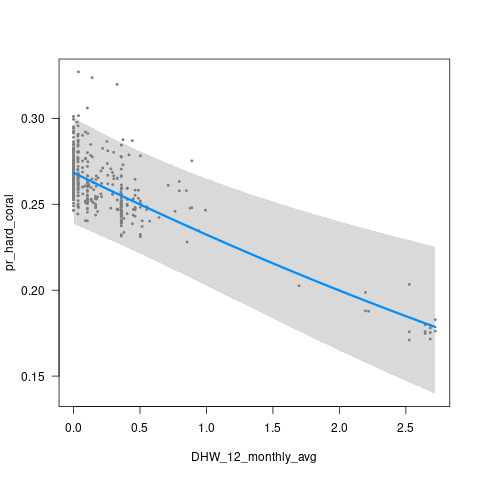

In [34]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("all_data_19.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ DHW_12_monthly_avg +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD10 = glmmTMB(pr_hard_coral ~ DHW_120_monthly_avg +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD20 = glmmTMB(pr_hard_coral ~ DHW_240_monthly_avg +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    print(summary(MOD10))
                    print("---------------20 YEARS------------------------------")
                    print(summary(MOD20))
                    visreg(MOD1, scale = 'response', partial=T)
                    

## Try modelling with other variables

### SST

Loading objects:
  my_df
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/regional_clusters/local_clusters)
Data: all_data_19

     AIC      BIC   logLik deviance df.resid 
 -1018.4   -998.2    514.2  -1028.4      411 

Random effects:

Conditional model:
 Groups                                          Name        Variance 
 local_clusters:(regional_clusters:country_code) (Intercept) 4.959e-02
 regional_clusters:country_code                  (Intercept) 1.572e-01
 country_code                                    (Intercept) 2.955e-09
 Std.Dev. 
 2.227e-01
 3.965e-01
 5.436e-05
Number of obs: 416, groups:  
local_clusters:(regional_clusters:country_code), 32; regional_clusters:country_code, 18; country_code, 4

Overdispersion parameter for beta family (): 30.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6072     0.1081  -14.87   <2e-16 ***
---
Signif. codes: 

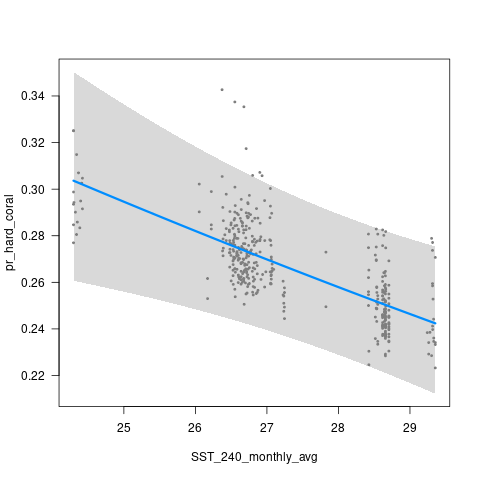

In [36]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("all_df_.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ SST_12_monthly_avg +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD10 = glmmTMB(pr_hard_coral ~ SST_120_monthly_avg +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD20 = glmmTMB(pr_hard_coral ~ SST_240_monthly_avg +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    print(summary(MOD10))
                    print("---------------20 YEARS------------------------------")
                    print(summary(MOD20))
                    visreg(MOD20, scale = 'response', partial=T)

### Distance to marine protected area

Loading objects:
  my_df
 Family: beta  ( logit )
Formula:          pr_hard_coral ~ dist_marine_protection
Data: all_data_19

     AIC      BIC   logLik deviance df.resid 
      NA       NA       NA       NA      413 


Overdispersion parameter for beta family (): 15.9 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)
(Intercept)            -1.351e+00         NA      NA       NA
dist_marine_protection -1.971e-06         NA      NA       NA


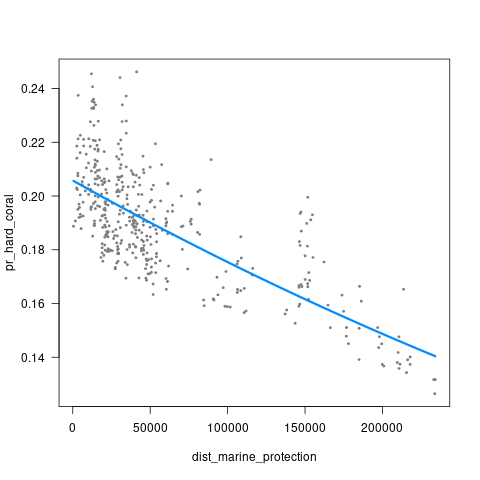

In [60]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("all_df_.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ dist_marine_protection,data=all_data_19,family=beta_family())
                    print(summary(MOD1))
                    visreg(MOD1, scale = 'response', partial=T)

df

### PAR

Loading objects:
  all_data_19
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/regional_clusters/local_clusters)
Data: all_data_19

     AIC      BIC   logLik deviance df.resid 
 -1018.4   -998.2    514.2  -1028.4      411 

Random effects:

Conditional model:
 Groups                                          Name        Variance 
 local_clusters:(regional_clusters:country_code) (Intercept) 4.959e-02
 regional_clusters:country_code                  (Intercept) 1.572e-01
 country_code                                    (Intercept) 2.955e-09
 Std.Dev. 
 2.227e-01
 3.965e-01
 5.436e-05
Number of obs: 416, groups:  
local_clusters:(regional_clusters:country_code), 32; regional_clusters:country_code, 18; country_code, 4

Overdispersion parameter for beta family (): 30.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6072     0.1081  -14.87   <2e-16 ***
---
Signif. c

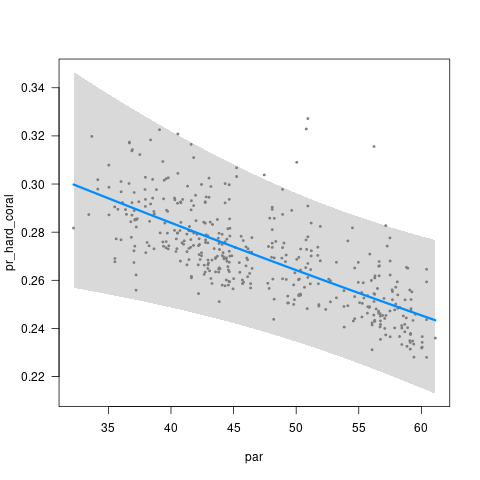

In [79]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("all_data_19.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ par +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    
                    
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    
                    print("---------------20 YEARS------------------------------")
                    
                    visreg(MOD1, scale = 'response', partial=T)

In [83]:
df["distance_agr_land"]

Index(['solar_rad_clear_sky', 'elevation', 'DHW', 'SST', 'par', 'closest_port',
       'year', 'distance_urban', 'dist_marine_protection', 'agr_type'],
      dtype='object')

### Distance Agriculture

Loading objects:
  all_data_19
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/regional_clusters/local_clusters)
Data: all_data_19

     AIC      BIC   logLik deviance df.resid 
 -1018.4   -998.2    514.2  -1028.4      411 

Random effects:

Conditional model:
 Groups                                          Name        Variance 
 local_clusters:(regional_clusters:country_code) (Intercept) 4.959e-02
 regional_clusters:country_code                  (Intercept) 1.572e-01
 country_code                                    (Intercept) 2.955e-09
 Std.Dev. 
 2.227e-01
 3.965e-01
 5.436e-05
Number of obs: 416, groups:  
local_clusters:(regional_clusters:country_code), 32; regional_clusters:country_code, 18; country_code, 4

Overdispersion parameter for beta family (): 30.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6072     0.1081  -14.87   <2e-16 ***
---
Signif. c

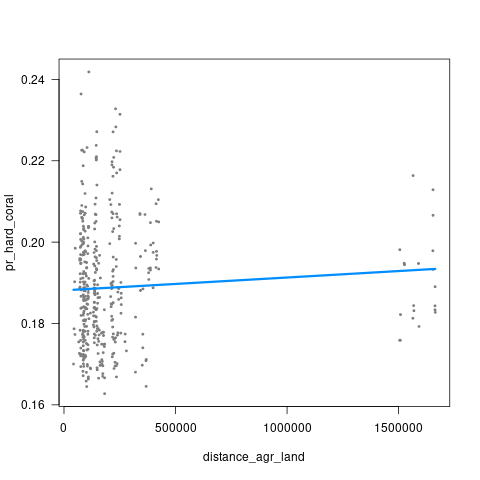

In [97]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("all_data_19.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ distance_agr_land ,data=all_data_19,family=beta_family())
                    
                    
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    
                    print("---------------20 YEARS------------------------------")
                    
                    visreg(MOD1, scale = 'response', partial=T)

### Distnace urban

Loading objects:
  all_data_19
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/regional_clusters/local_clusters)
Data: all_data_19

     AIC      BIC   logLik deviance df.resid 
 -1018.4   -998.2    514.2  -1028.4      411 

Random effects:

Conditional model:
 Groups                                          Name        Variance 
 local_clusters:(regional_clusters:country_code) (Intercept) 4.959e-02
 regional_clusters:country_code                  (Intercept) 1.572e-01
 country_code                                    (Intercept) 2.955e-09
 Std.Dev. 
 2.227e-01
 3.965e-01
 5.436e-05
Number of obs: 416, groups:  
local_clusters:(regional_clusters:country_code), 32; regional_clusters:country_code, 18; country_code, 4

Overdispersion parameter for beta family (): 30.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6072     0.1081  -14.87   <2e-16 ***
---
Signif. c

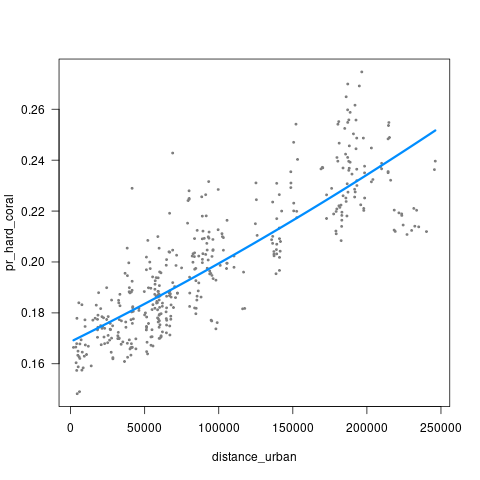

In [98]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("all_data_19.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ distance_urban + (1 +country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    
                    
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    
                    print("---------------20 YEARS------------------------------")
                    
                    visreg(MOD1, scale = 'response', partial=T)

In [113]:
df.columns[10:40]

Index(['solar_rad_clear_sky', 'elevation', 'DHW', 'SST', 'par', 'closest_port',
       'year', 'distance_urban', 'dist_marine_protection', 'agr_type',
       'Broad_type', 'dist_agr_AUS', 'distance_to_mine_area', 'nigh_avg_2012',
       'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2012', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2016', 'distance_agr_land',
       'wind_12_monthly_avg', 'wind_12_monthly_min', 'wind_12_monthly_max',
       'wind_12_monthly_range', 'wind_2year_exclude_avg'],
      dtype='object')

### Wind average

Loading objects:
  my_df
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/regional_clusters/local_clusters)
Data: all_data_19

     AIC      BIC   logLik deviance df.resid 
 -1018.4   -998.2    514.2  -1028.4      411 

Random effects:

Conditional model:
 Groups                                          Name        Variance 
 local_clusters:(regional_clusters:country_code) (Intercept) 4.959e-02
 regional_clusters:country_code                  (Intercept) 1.572e-01
 country_code                                    (Intercept) 2.955e-09
 Std.Dev. 
 2.227e-01
 3.965e-01
 5.436e-05
Number of obs: 416, groups:  
local_clusters:(regional_clusters:country_code), 32; regional_clusters:country_code, 18; country_code, 4

Overdispersion parameter for beta family (): 30.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6072     0.1081  -14.87   <2e-16 ***
---
Signif. codes: 

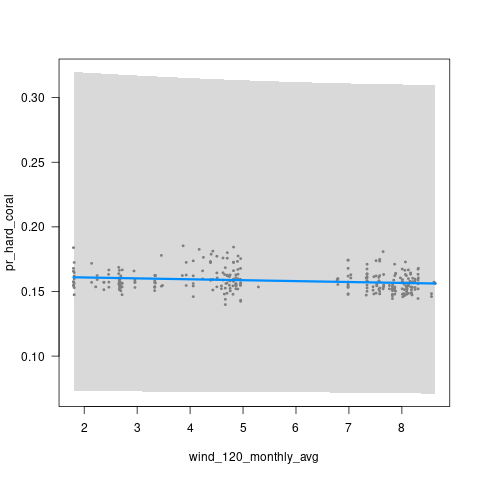

In [128]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("all_df_.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ wind_12_monthly_avg +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD10 = glmmTMB(pr_hard_coral ~ wind_120_monthly_avg +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    print(summary(MOD10))
                    
                    visreg(MOD10, scale = 'response', partial=T)

### Max Wind speed

Loading objects:
  my_df
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/regional_clusters/local_clusters)
Data: all_data_19

     AIC      BIC   logLik deviance df.resid 
 -1018.4   -998.2    514.2  -1028.4      411 

Random effects:

Conditional model:
 Groups                                          Name        Variance 
 local_clusters:(regional_clusters:country_code) (Intercept) 4.959e-02
 regional_clusters:country_code                  (Intercept) 1.572e-01
 country_code                                    (Intercept) 2.955e-09
 Std.Dev. 
 2.227e-01
 3.965e-01
 5.436e-05
Number of obs: 416, groups:  
local_clusters:(regional_clusters:country_code), 32; regional_clusters:country_code, 18; country_code, 4

Overdispersion parameter for beta family (): 30.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6072     0.1081  -14.87   <2e-16 ***
---
Signif. codes: 

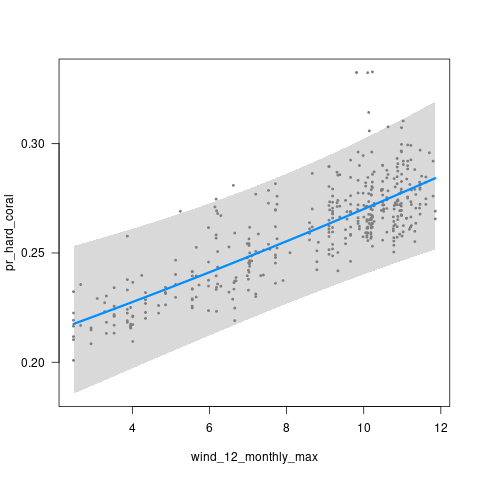

In [130]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("all_df_.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ wind_12_monthly_max +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    MOD10 = glmmTMB(pr_hard_coral ~ wind_120_monthly_max +  (1 | country_code/regional_clusters/local_clusters),data=all_data_19,family=beta_family())
                    
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    print(summary(MOD10))
                    
                    visreg(MOD1, scale = 'response', partial=T)